In [5]:
import pandas as pd
import seaborn as sns
import requests
import copy
sns.set(style="darkgrid", rc={'figure.figsize':(12,8)})

## define functions

In [6]:
def url2df(url):
    f = requests.get(url)
    df_raw = pd.read_json(f.text)
    df_raw.scannedDevicesMinTimestamp= pd.to_datetime(df_raw.scannedDevicesMinTimestamp) + pd.offsets.Hour(3) #Israel Summer Time
    df_raw.scannedDevicesMaxTimestamp= pd.to_datetime(df_raw.scannedDevicesMaxTimestamp) + pd.offsets.Hour(3) #Israel Summer Time
    df_raw = df_raw.rename(columns={'scannedDevicesMinTimestamp': 'scannedDevicesMinTime',
                    'scannedDevicesMaxTimestamp': 'scannedDevicesMaxTime'})
    df_raw = df_raw.sort_values("scannedDevicesMaxTime") # sorting by last time!
    return df_raw

In [7]:
def scannedDevices2df(scannedDevices):
    df_sd = pd.json_normalize(scannedDevices)
    if df_sd.empty:
#         print('No scans avaliable')
        return df_sd
    df_sd = df_sd.rename(columns={'timestamp': 'time'})
    df_sd.time = pd.to_datetime(df_sd.time) + pd.offsets.Hour(3) #Israel Summer Time
    df_sd = df_sd.sort_values("time")
    return df_sd

In [8]:
def allScannedDevicesInTime(df, rel_time, window_size_minutes=0):
    sd = pd.DataFrame()
    id_suffix = df.scanningDeviceEddystoneUid[0][-12:]
    time_window = pd.offsets.Minute(window_size_minutes/2)
    mask = (df.scannedDevicesMinTime <= rel_time+time_window) & (df.scannedDevicesMaxTime >= rel_time-time_window)
    if not any(mask):
        print('No date at this time from: ' + id_suffix)
        return sd
    for row in df[mask].index:
        sd_new = scannedDevices2df(df.scannedDevices[row])
        if sd_new.empty:
            print('No scans avaliable from: ' + id_suffix)
            continue
        sd = pd.concat([sd, sd_new], ignore_index=True)
    return sd

## access raw data

In [9]:
url = "https://us-central1-social-protection-46da6.cloudfunctions.net/getDeviceScans?device_id="

bleId = {"Pocophone_JBobrutsky": "7BB8BD884D95DBBD613526BE32778B20",
        "OnePlus6_JBobrutsky": "7BB8BD884D95DBBD613588BD06DA4164",
        "Pocophone_RCohen": "7BB8BD884D95DBBD61355606EBDA8C29",
        "GalaxyS6_RCohen":"7BB8BD884D95DBBD613591F40E000CF5",
        "Mi9TPro_YDanan":"7BB8BD884D95DBBD6135FF68FE505BBB",
        "GalaxyS7_YDanan":"7BB8BD884D95DBBD613537C1077BC334",}


No scans avaliable from: 26BE32778B20
No scans avaliable from: 26BE32778B20
No scans avaliable from: 26BE32778B20
No scans avaliable from: 26BE32778B20
No scans avaliable from: 26BE32778B20
No scans avaliable from: 26BE32778B20
No date at this time from: 5606EBDA8C29
No date at this time from: 91F40E000CF5
No scans avaliable from: FF68FE505BBB
No date at this time from: 37C1077BC334


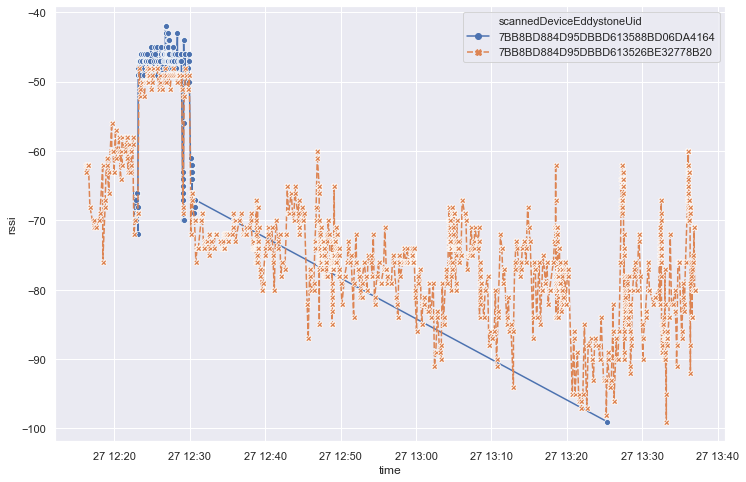

In [10]:
df1 = url2df(url= url + bleId["Pocophone_JBobrutsky"])
df2 = url2df(url= url + bleId["OnePlus6_JBobrutsky"])
df3 = url2df(url= url + bleId["Pocophone_RCohen"])
df4 = url2df(url= url + bleId["GalaxyS6_RCohen"])
df5 = url2df(url= url + bleId["Mi9TPro_YDanan"])
df6 = url2df(url= url + bleId["GalaxyS7_YDanan"])

rel_time = pd.to_datetime("2020-03-27 13:00:00") #Local time! :D
window_size_minutes = 60
sd1 = allScannedDevicesInTime(df1, rel_time, window_size_minutes)
sd2 = allScannedDevicesInTime(df2, rel_time, window_size_minutes)
sd3 = allScannedDevicesInTime(df3, rel_time, window_size_minutes)
sd4 = allScannedDevicesInTime(df4, rel_time, window_size_minutes)
sd5 = allScannedDevicesInTime(df5, rel_time, window_size_minutes)
sd6 = allScannedDevicesInTime(df6, rel_time, window_size_minutes)
sd = pd.concat([sd1, sd2, sd3, sd4,sd5, sd6], ignore_index=True)

if not sd.empty:
    sns.lineplot(x="time", y="rssi",
                 hue="scannedDeviceEddystoneUid",
                 style="scannedDeviceEddystoneUid",
                 data=sd, markers=True)